### **Transfomer**

- 트랜스포머(Transformer) 모델은 2017년 "Attention is All You Need" 논문에서 처음 제안된 혁신적인 모델로, 기존의 순차적인 시퀀스 모델(RNN, LSTM)을 사용하지 않고 Self-Attention 메커니즘을 도입함으로써 기존 모델의 한계를 극복함
- 이 모델은 자연어 처리(NLP), 컴퓨터 비전(Vision) 등 다양한 분야에서 널리 사용되며, 빠르고 효율적인 병렬 처리를 통해 높은 성능을 제공합니다.

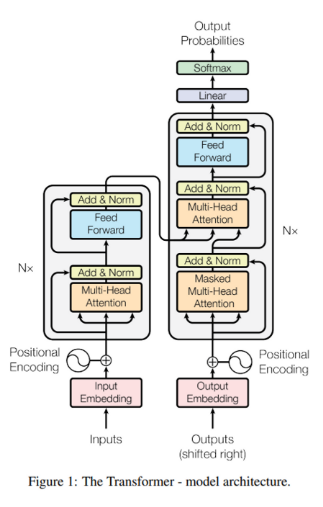
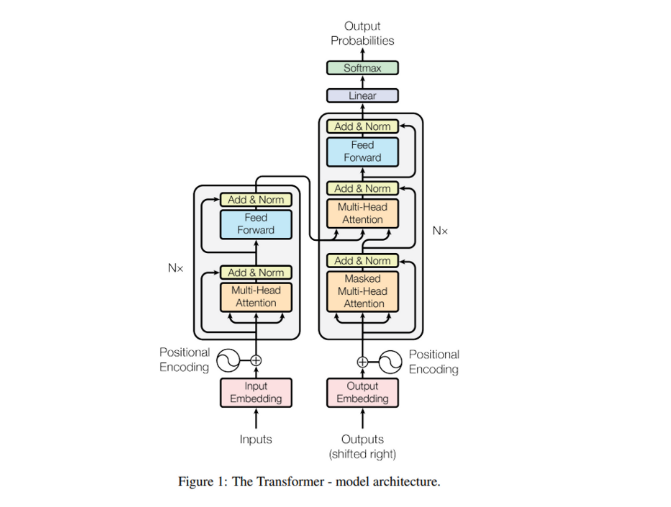
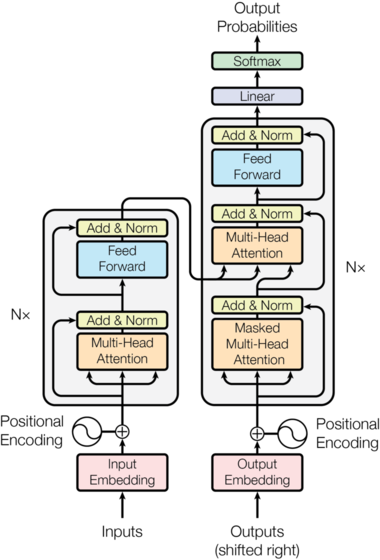

### **Positional Embedding**

- 입력 토큰을 학습 가능한 임베딩 벡터를 사용해 위치 정보를 학습 하는 방식 
- 논문에서는 Positional Embedding을 사용하지 않고 고정된 위치를 나타내는 Positional Encoding을 사용함 

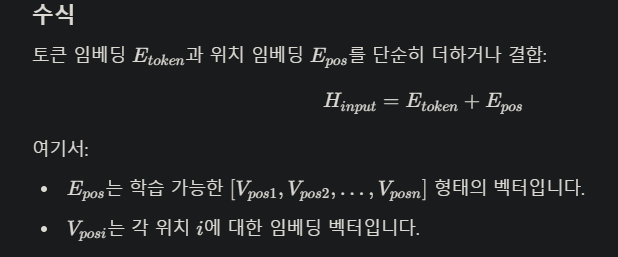

In [8]:
import torch
import torch.nn as nn

class PositionalEmbedding(nn.Module):
    def __init__(self, input_embedding, max_len, d_model):
        super().__init__()
        
        # 입력 임베딩
        self.input_embedding = input_embedding
        
        # positional embedding
        self.positional_embedding = nn.Embedding(max_len, d_model)
        
    def forward(self, x):
        
        # x.size(1) : seq_len
        # seq_len 만큼의 positional embedding을 생성
        pos = torch.arange(x.size(1), device=x.device).expand_as(x)
        
        # positional embedding을 더해줌
        return self.input_embedding(x) + self.positional_embedding(pos)

# Bert에서 사용하는 Positional Embedding
class PositionalEmbedding(nn.Module):
    def __init__(self, input_embedding, max_len, d_model):
        super().__init__()
        
        self.input_embedding = input_embedding
        self.positional_embedding = nn.Embedding(max_len, d_model)
        
    def forward(self, x):
        
        # x.size(1) : seq_len
        pos = torch.arange(0, x.size(1)).unsqueeze(0)
        pos_embedded = self.positional_embedding(pos)
        return self.input_embedding(x) + pos_embedded.expand(x.size(0), -1, -1)

### **Positional Encoding**

- Positional Embedding과 다르게 학습 가능하지 않은 고정된 위치 벡터 
- 위치정보를 수학적으로 표현하여 워드 임베딩에 더해 단어의 위치 정보를 추가함
- $Sin, Cos$ 함수를 사용 -> 주기함수이기 때문에 단어의 상대적 위치를 반영 

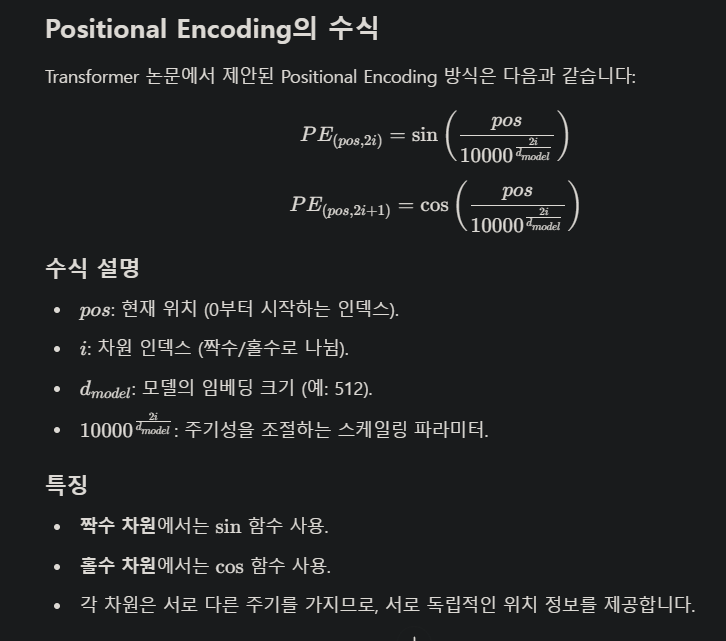

$$
\frac{\text{pos}}{10000^{\frac{2i}{d_{\text{model}}}}} = \text{pos} \cdot 10000^{-\frac{2i}{d_{\text{model}}}}
$$

주어진 식:
$$
10000^{-\frac{2i}{d_{\text{model}}}}
$$

로그를 사용하여 변환:
$$
10000^{-\frac{2i}{d_{\text{model}}}} = \exp\left(-\frac{2i}{d_{\text{model}}} \cdot \log(10000)\right)
$$

지수 함수의 성질:
$$
\exp(a \cdot \log(b)) = b^a
$$

따라서:
$$
\exp\left(-\frac{2i}{d_{\text{model}}} \cdot \log(10000)\right) = 10000^{-\frac{2i}{d_{\text{model}}}}
$$


In [ ]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len):
        super().__init__()
        
        # positional encoding
        self.pe = torch.zeros(max_len, d_model)
        pos = torch.arange(0, max_len, dtype = torch.float).unsqueeze(1)
        
        div_term = torch.exp(torch.arange(0, d_model, 2) * -(math.log(10000.0) / d_model))
        
        # 짝수 인덱스에는 sin 함수 적용
        self.pe[:, 0::2] = torch.sin(pos * div_term)
        
        # 홀수 인덱스에는 cos 함수 적용
        self.pe[:, 1::2] = torch.cos(pos * div_term)
        
        # 데이터의 차원을 맞춰주기 위해 unsqueeze X의 shape : [batch_size, seq_len, d_model]
        self.pe = self.pe.unsqueeze(0) # batch 차원 추가[1, max_len, d_model]
        
    def forward(self, x):
        return x + self.pe[:, :x.size(1), :]
        

### **Self Attention**

- 입력 시퀀스내 각 단어가 다른 모든 단어와의 관계를 학습하는 Machanism(Query, Key, Value)
- 자기 자신과 다른 단어들과의 관계를 Attention 하여 Self Attention 이라고 함 

### **Multi Head Attention**

- Attention을 여러개의 Head로 병렬계산하여 하나로 합침 
- 각 Head가 서로다른 정소/시각의 관계를 학습(한명을 여러 사진사가 여러 각도에서 찍어 사람의 다양한 특징을 파악하는것과 같음)

- 각 Head는 독립적인 가중치로 서로 다른 Attention Score 계산 
- Head 별 결과를 Concatenate 하여 선형변환 

--- 

### 1. Query, Key, Value 생성
- Query(질문) : 내가 찾고자 하는 정보(무엇을 찾고 있는가)
- Key(답변) : 질문에 대한 답변 (어떤 정보를 가지고 있는가)
- Value(정답) : Key의 의미를 담은 벡터 실제 정답 (실제 정답은 어떤것인가)
- Q, K, V는 내적할 워드 임베딩 벡터를 선형 변환하는 FC Layer 

$$
\mathbf{Q} = \mathbf{X} \mathbf{W}_Q, \quad \mathbf{K} = \mathbf{X} \mathbf{W}_K, \quad \mathbf{V} = \mathbf{X} \mathbf{W}_V
$$

---

### 2. Attention Score (유사도 계산)
Query와 Key의 내적(dot product)을 사용해 유사도 점수를 계산. $\sqrt{d_k}$로 나누어 점수를 스케일링.

$$
\text{Score}_{ij} = \frac{\mathbf{Q}_i \cdot \mathbf{K}_j^\top}{\sqrt{d_k}}
$$

---

### 3. Softmax로 가중치 계산
Score에 Softmax를 적용하여 각 단어가 다른 단어와 얼마나 관련 있는지 확률 분포로 변환환.

$$
\text{Attention Weight}_{ij} = \text{Softmax}\left(\frac{\mathbf{Q}_i \cdot \mathbf{K}_j^\top}{\sqrt{d_k}}\right)
$$

---

### 4. Attention 출력 (가중합)
Softmax로 계산된 가중치를 Value 벡터에 곱한 후, 이를 가중합하여 최종 Attention 출력을 생성.

$$
\text{Attention}(\mathbf{Q}, \mathbf{K}, \mathbf{V}) = \text{Softmax}\left(\frac{\mathbf{Q}\mathbf{K}^\top}{\sqrt{d_k}}\right) \mathbf{V}
$$

---

### 5. Multi-Head Attention
멀티헤드 어텐션은 여러 헤드에서 독립적으로 Attention을 계산한 뒤, 이를 결합하여 최종 출력을 생성.

$$
\text{MultiHead}(\mathbf{Q}, \mathbf{K}, \mathbf{V}) = \text{Concat}(\text{head}_1, \ldots, \text{head}_h)\mathbf{W}^O
$$

각 Head는 다음과 같이 계산:
$$
\text{head}_i = \text{Attention}(\mathbf{Q} \mathbf{W}_Q^{(i)}, \mathbf{K} \mathbf{W}_K^{(i)}, \mathbf{V} \mathbf{W}_V^{(i)})
$$

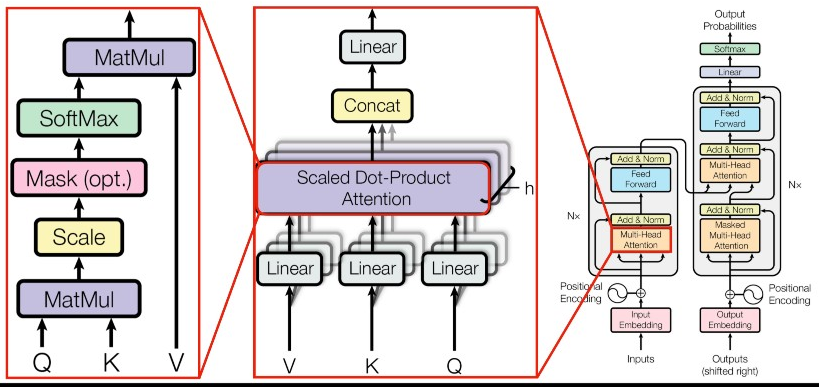
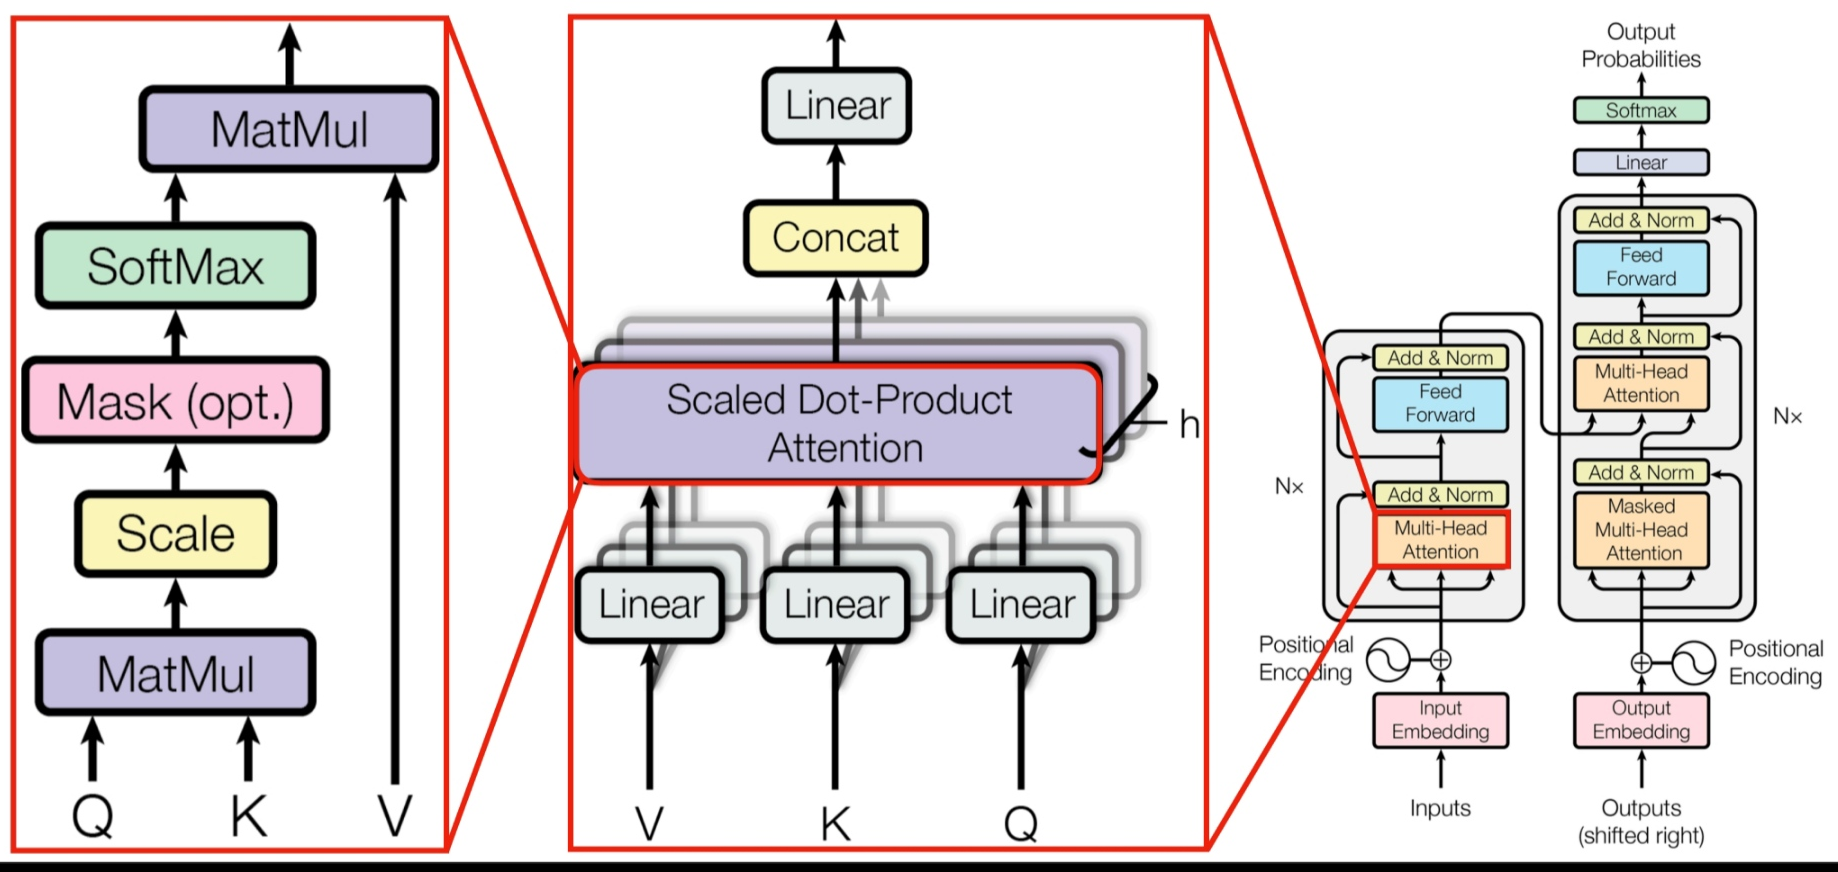
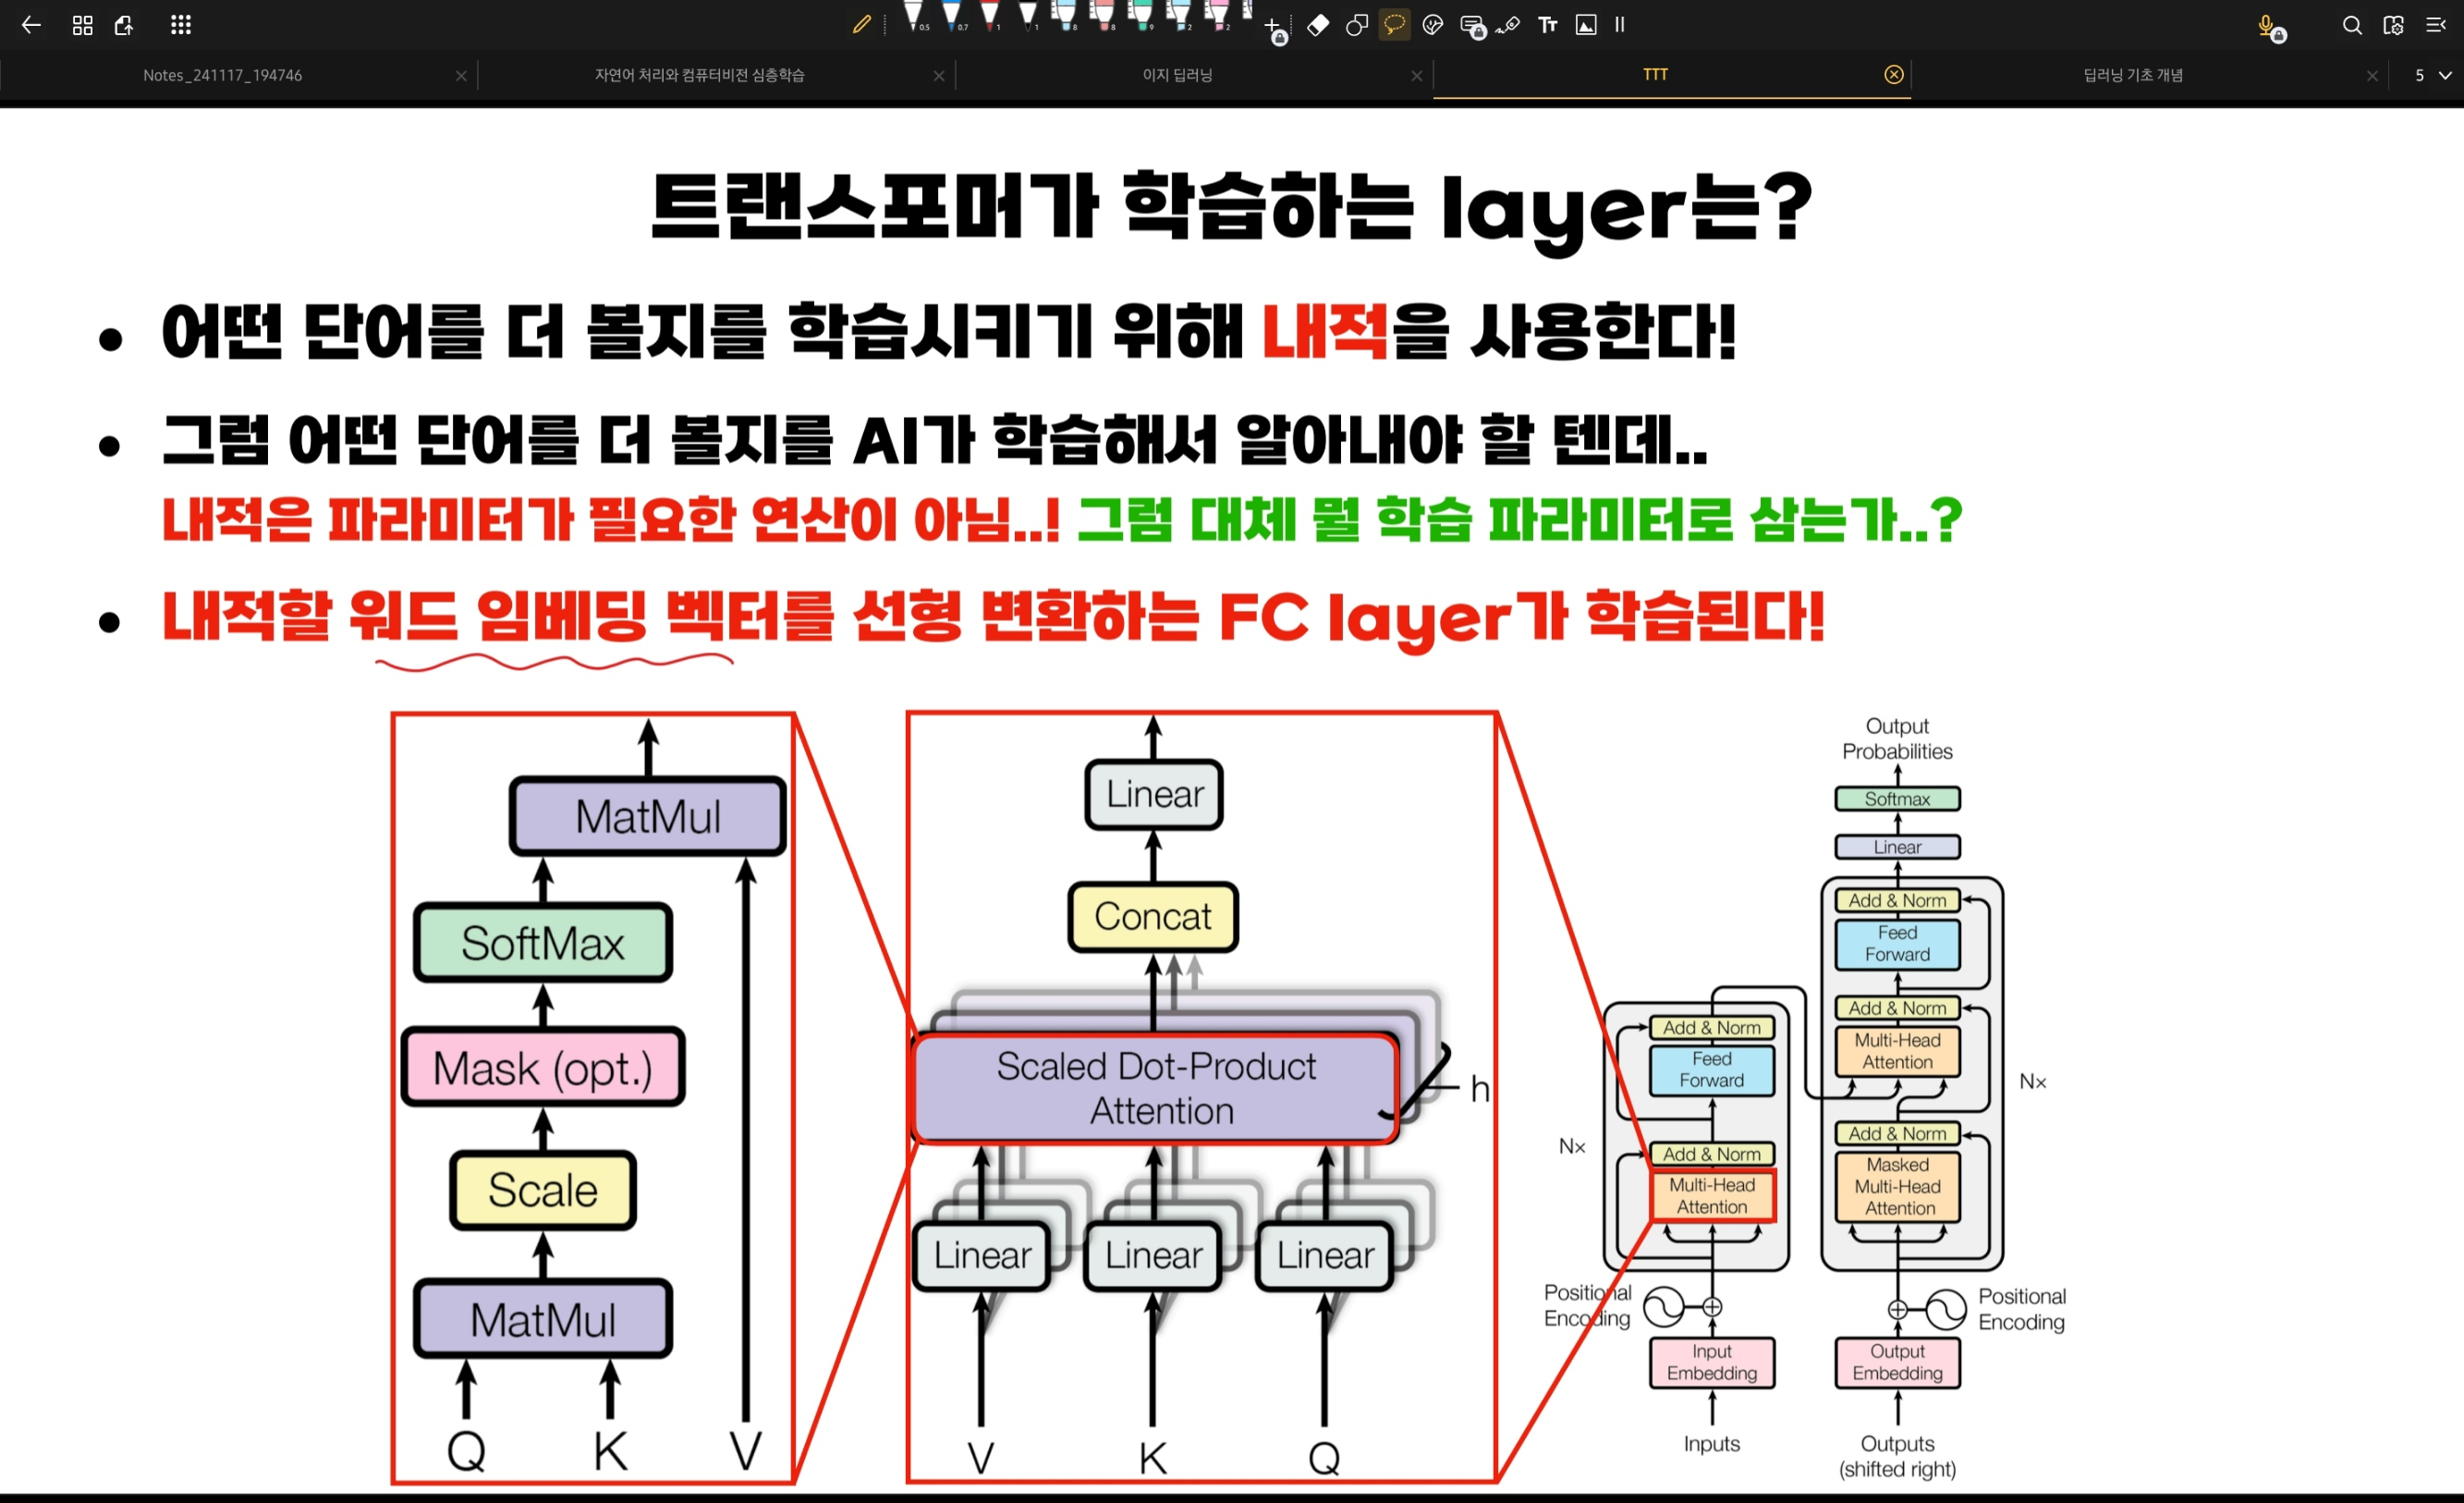

In [ ]:
from einops import rearrange

class MHA(nn.Moudle):
    def __init__(self, d_model, n_heads):
        super().__init__()
        
        self.d_model = d_model
        self.n_heads = n_heads
        
        self.fc_q = nn.Linear(d_model, d_model)
        self.fc_k = nn.Linear(d_model, d_model)
        self.fc_v = nn.Linear(d_model, d_model)
        self.fc_o = nn.Linear(d_model, d_model)
        
        self.scale = torch.sqrt(torch.Tensor(d_model // n_heads))
        
    def forward(self, Q, K, V, mask = None):
        
        # shape [개, 단, 차] -> [batch_size, seq_len, d_model] = [한번에 들어가는 문장의 개수, 단어의 개수, 임베딩 차원]
        Q = self.fc_q(Q)
        K = self.fc_q(K)
        V = self.fc_q(V) 
        
        # Split Head 
        # 개 단 차 -> 개 해 단 차  [batch_size, seq_len, d_model] -> [batch_size, n_heads, seq_len, head_dim]
        
        # Attention 계산 병렬 처리를 효율적으로 하기 위해 [batch_size, n_heads, seq_len, head_dim] 로 차원 순서 변경
        Q = rearrange(Q, 'b s (h d) -> b h s d', h = self.n_heads)   # b, s, d에서 d를 (h, d) = (h x d) 라고 할거고 h = n_heads 라고 지정할거야
        K = rearrange(K, 'b s (h d) -> b h s d', h = self.n_heads)  
        V = rearrange(V, 'b s (h d) -> b h s d', h = self.n_heads)  
        
        # Attention Score 계산  Q와 K의 행렬곱을 위해 K의 차원을 바꿔서 맞춰줌
        attention_score = Q @ K.transpose(-2, -1) / self.scale

        # masked self attention : 미래시점의 값에 극단적인 음수값을 주어 softmax를 거친 후 0에 가깝게 만들어줌(decoder), 
        # encoder는 패딩 토큰을 제외하고 나머지 토큰들끼리만 attention을 하기 위해 패딩을 마스크함
        
        # 마스크 적용 (Boolean Mask 또는 Float Mask)
        if mask is not None:
            if mask.dtype == torch.bool:
                
                # Boolean type 일때 
                # attention_score[mask] = -1e10  
                attention_score = attention_score.masked_fill(mask, float('-inf'))  
            else:
                # Float type 일때
                # attention_score = attention_score.masked_fill(mask== float('-inf'), -1e10)
                attention_score = attention_score + mask  # Float Mask
        
        # True가 mask 되야함 
        """F T T T T 
           F F T T T 
           F F F T T
           F F F F T"""
        
        # float 형식으로 마스킹 할려면 
        """0 -inf -inf -inf -inf
           0   0  -inf -inf -inf
           0   0    0  -inf -inf
           0   0    0    0  -inf"""
        
        
        # Attention Weights : Attention Score를 Softmax에 통과 시켜 확률분포로 변환
        attention_weights = torch.softmax(attention_score, dim = -1)
        
        # Value와의 Weighted Sum
        attention = attention_weights @ V
        
        # Concatenate Heads num_heads * head_dim = d_model
        # num_heads와 head_dim을 다시 d_model로 합쳐주기 위해 1, 2의 위치를 바꾸고 view를 하여 합쳐줌 
        x = rearrange(attention, 'b h s d -> b s (h d)')
        
        # FC Layer 
        x = self.fc_o(x)
        
        return x
    
        # rearrange를 사용하지 않는다면 
        
        # batch_size = Q.size(0)
        
        # Q = self.fc_q(Q)
        # K = self.fc_k(K)
        # V = self.fc_v(V)
        
        # # Split head   (batch_size, seq_len, d_model) -> (batch_size, n_heads, seq_len, head_dim)  (개 단 차 -> 개 해 단 차)
        # Q = Q.reshape(batch_size, -1, self.n_heads, self.d_model // self.n_heads).transpose(2, 1)     # transpose(2, 1) -> permute(0, 2, 1, 3)  
        # K = K.reshape(batch_size, -1, self.n_heads, self.d_model // self.n_heads).transpose(2, 1)     # transpose(2, 1) -> permute(0, 2, 1, 3)
        # V = V.reshape(batch_size, -1, self.n_heads, self.d_model // self.n_heads).transpose(2, 1)     # transpose(2, 1) -> permute(0, 2, 1, 3)
        
        # # Attention Score
        # attention_score = Q @ K.transpose(-2, -1) / self.scale
        
        # # Mask
        # if mask is not None:
        #     attention_score = attention_score.masked_fill(mask == 0, -1e10)

        # # Attention Weights
        # attention_weights = torch.softmax(attention_score, dim = -1)
        
        # # Weights sum 
        # attention = attention_weights @ V
        
        # # Concatenate heads   (batch_size, n_heads, seq_len, head_dim) -> (batch_size, seq_len, d_model)  (개 해 단 차 -> 개 단 차)
        # x = attention.transpose(2, 1).reshape(batch_size, -1, self.d_model)   # x = attention.transpose(2, 1).contiguous().view(batch_size, -1, self.d_model)
        
        # x = self.fc_o(x)
        
# Feed Forward NetWork        
class FeedForward(nn.Module):
    def __init__(self, d_model, d_ff, drop_p):
        super().__init__()
        
        self.linear = nn.Sequential(nn.Linear(d_model, d_ff),
                                    nn.ReLU(),
                                    nn.Dropout(drop_p),
                                    nn.Linear(d_ff, d_model))
    
    def forward(self, x):
        x = self.linear(x)
        return x

### **Encoder**

- 인코더는 sentence를 input으로 받아 하나의 vector를 생성하는 함수임
- 문장의 문맥을 함축해 담은 vector임
- 문장의 정보들을 빠뜨리지 않고 압축하는 것을 목표로 학습됨

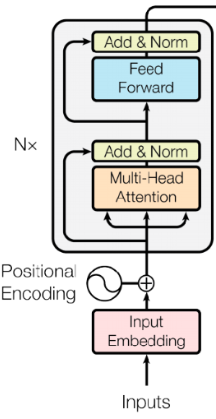
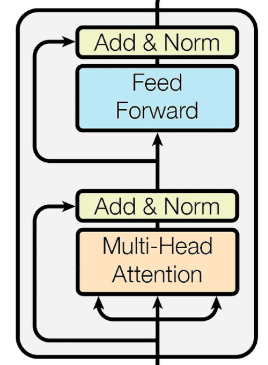

In [119]:
## **Encoder Layer**

class EncoderLayer(nn.Module):
    def __init__(self, d_model, d_ff, n_heads, drop_p):
        super().__init__()
        
        # Multi Head Attention
        self.attention = MHA(d_model, n_heads)
        self.attention_norm = nn.LayerNorm(d_model)
        
        # Feed Forward
        self.FF = FeedForward(d_model, d_ff, drop_p)
        self.FF_norm = nn.LayerNorm(d_model)
        
        self.drop = nn.Dropout(drop_p)
        
    def forward(self, x, enc_mask):

        """
        Args:
            x: 입력 텐서 (batch_size, seq_len, d_model)
            enc_mask: 패딩 토큰 마스크 (batch_size, seq_len, seq_len)
        
        Returns:
            x: Encoder Layer의 출력 (batch_size, seq_len, d_model)
        """
                
        # Multi-head attention   # 인코더의 마스크 왜 있냐 : 패딩 토큰을 제외하고 나머지 토큰들끼리만 attention을 하기 위해 패딩을 마스크함 
        residual_mha, _ = self.attention(x, x, x, enc_mask)  # (Q, K, V, mask)
        
        # Add & Norm(Residual Connection & Layer Normalization)
        
        # Dropout 
        residual_mha = self.drop(residual_mha)
        
        # Residual Connection & Layer Normalization
        x = self.attention_norm(x + residual_mha)
        
        # Feed Forward
        residual_FF = self.FF(x)
        
        # dropout 
        residual_FF = self.drop(residual_FF)
        
        # Residual Connection & Layer Normalization
        x = self.FF_norm(x + residual_FF)
        
        return x
        
## **Encoder**
class Encoder(nn.Module):
    def __init__(self, input_embedding, max_len, n_layers, d_model, d_ff, n_heads, drop_p):

        """
        Args:
            input_embedding : 입력 임베딩딩
            max_len: 최대 시퀀스 길이 (Positional Encoding에 사용).
            num_layers: Encoder Layer의 개수.
            d_model: 모델의 임베딩 차원 (전체 벡터 크기).
            d_ff: Feed-Forward Network에서 중간 레이어의 차원 크기.
            n_heads: Multi-Head Attention의 헤드 개수.
            drop_p: 드롭아웃 비율.
        """
        
        super().__init__()
        
        self.input_embedding = input_embedding    
        
        # Positional Embedding
        self.pos_embedding = nn.Embedding(max_len, d_model)
        
        # Positional Encoding
        # self.pos_encoding = PositionalEncoding(d_model, max_len)
        
        # dropout 
        self.dropout = nn.Dropout(drop_p)
        
        # Encoder Layers
        self.layers = nn.ModuleList([EncoderLayer(d_model, d_ff, n_heads, drop_p) for _ in range(n_layers)])
        
    def forward(self, src, mask):
        """
        Args:
            src: 입력 벡터 (batch_size, seq_len, d_model).
            src_mask: 입력 마스크 (batch_size, n_heads, seq_len, seq_len).
        
        Returns:
            src: Encoder의 출력 (batch_size, seq_len, d_model).
        """       
        # 시퀀스 길이 만큼 위치를 나타내는 pos_embedding을 만들어줌 
        pos = torch.arange(src.shape[1]).expand_as(src)
        
        # bert에서 사용되는 Positional Embedding 
        # pos = torch.arange(0, x.size(0)).unsqueeze(0)
                
        # input_embedding + pos_embedding을 해서 위치정보를 가진 임베딩 벡터 생성
        x = self.input_embedding(src) + self.pos_embedding(pos)
        x = self.dropout(x)
        
        # Positional Encoding 사용 return : x + self.pe[:, :x.size(1), :]
        # x = self.pos_encoding(src)
        
        # layer 생성
        for layer in self.layers:
            x, _ = layer(x, mask)
            
        return x

### **Decoder**

- Transformer의 **디코더(Decoder)** 는 인코더에서 생성된 문맥 정보를 바탕으로 출력을 생성.
- 디코더는 Auto-Regressive(자기회귀) 방식으로 작동하며, 이전 단계의 출력 토큰들을 참조하여 다음 출력 토큰을 예측.

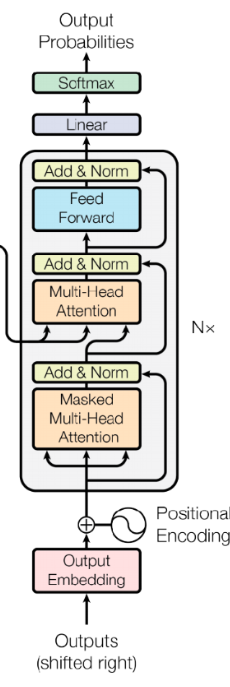

In [ ]:
## **Decoder Layer**

class DecoderLayer(nn.Module):
    def __init__(self, d_model, n_heads, d_ff, drop_p):
        super().__init__()
        
        # Maksed Self Attetnion
        self.masked_attention = MHA(d_model, n_heads)
        self.masked_attention_norm = nn.LayerNorm(d_model)
        
        # Encoder-Deocder Attention
        self.en_de_attention = MHA(d_model, n_heads)
        self.en_de_attention_norm = nn.LayerNorm(d_model)
        
        # FeedForward
        self.FF = FeedForward(d_model, d_ff, drop_p)
        self.FF_norm = nn.LayerNorm(d_model)
        
        # dropout
        self.dropout = nn.Dropout(drop_p)
        
    def forward(self, x, enc_out, dec_mask, enc_dec_mask):
        
        # Masked Self Attention
        residual_mha, _ = self.masked_attention(x, x, x, dec_mask)  # (Q, K, V, mask)
        
        # Add & Norm(Residual Connection & Layer Normalization)
        
        # dropout
        residual_mha = self.dropout(residual_mha)
        
        # Residual Connection & Layer Normalization
        x = self.masked_attention_norm(x + residual_mha)
        
        # Encoder - Decoder Attention(Q는 디코더로부터 K,V는 인코더로부터!!)
        residual_atten, _ = self.en_de_attention(x, enc_out, enc_out, enc_dec_mask) 
        
        # Add & Norm(Residual Connection & Layer Normalization)
        
        # dropout
        residual_atten = self.dropout(residual_atten)
        
        # Residual Connection, Layer Norm 
        x = self.en_de_attention_norm(x + residual_atten)
        
        # Feed Forward
        residual_FF = self.FF(x)
        residual_FF = self.dropout(residual_FF)
        
        # Add & Norm
        x = self.FF_norm(x + residual_FF)
        
        return x
        
## **Decoder**   

class Decoder(nn.Module):
    def __init__(self, input_embedding, max_len, n_layers, d_model, d_ff, n_heads, drop_p):
        super().__init__()
        
        # Output Embedding
        self.input_embedding = input_embedding
        
        # Positional Embedding
        self.pos_embedding = nn.Embedding(max_len, d_model)
        
        # dropout
        self.dropout = nn.Dropout(drop_p)
        
        # Decoder Layers
        self.layers = nn.ModuleList([DecoderLayer(d_model, n_heads, d_ff, drop_p) for _ in range(n_layers)])
        
        # FC Layer
        self.fc_out = nn.Linear(d_model, vocab_size)
        
    def forward(self, trg, enc_out, dec_mask, enc_dec_mask):
        
        # Positional Embedding
        pos = torch.arange(trg.shape[1]).expand_as(trg)   # (batch_size, seq_len)
        x = self.input_embedding(trg) + self.pos_embedding(pos)  # (batch_size, seq_len, d_model)
        
        # dropout 
        x = self.dropout(x)
        
        for layer in self.layers:
            x = layer(x, enc_out, dec_mask, enc_dec_mask)
            
        x = self.fc_out(x)
        
        return x

### **Transformer**

In [ ]:
class Transformer(nn.Moudle):
    def __init__(self, vocab_size, max_len, n_layers, d_model, d_ff, n_heads, drop_p):
        super().__init__()
        
        # Input Embedding
        self.input_embedding = nn.Embedding(vocab_size, d_model)
        
        # Encoder 
        self.encoder = Encoder(self.input_embedding, max_len, n_layers, d_model, d_ff, n_heads, drop_p)
        
        # Decoder
        self.decoder = Decoder(self.input_embedding, max_len, n_layers, d_model, d_ff, n_heads, drop_p)
        
        self.n_heads = n_heads
        
    # Encoder mask(입력 시퀀스의 패딩 토큰을 마스킹)
    def make_enc_mask(self, src): # src: (batch_size, seq_len) (개 단)
        
        # src의 각 값이 pad_idx와 같은지 비교하여 패딩 위치를 True/False로 나타내는 텐서를 생성
        enc_mask = (src == pad_idx).unsqueeze(1).unsqueeze(2) # (batch_size, 1, 1, seq_len)
        enc_mask = enc_mask.expand(src.shape[0], self.n_heads, src.shape[1], src.shape[1]) # (batch_size, n_heads, seq_len, seq_len)

        """ src pad mask (문장 마다 다르게 생김. 이건 한 문장에 대한 pad 행렬)
        F F T T
        F F T T
        F F T T
        F F T T
        """
               
        return enc_mask
    
    # Decoder masked self attention mask(현재 시점 이후의 단어들을 마스킹)
    def make_dec_mask(self, trg): # trg: (batch_size, seq_len) (개 단)
        
        # trg의 각 값이 pad_idx와 같은지 비교하여 패딩 위치를 True/False로 나타내는 텐서를 생성
        trg_pad_mask = (trg == pad_idx).unsqueeze(1).unsqueeze(2)
        trg_pad_mask = trg_pad_mask.expand(trg.shape[0], self.n_heads, trg.shape[1], trg.shape[1])
    
        """ trg pad mask
        F F F T T
        F F F T T
        F F F T T
        F F F T T
        F F F T T
        """
        
        
        
        # 대각선을 기준으로 위쪽을 True로 채움
        # torch.tril() : 텐서의 **하삼각 행렬(lower triangular matrix)**만 남기고, 나머지 위치는 0으로 설정, 상삼각 행렬은 0으로 하삼각 행렬은 1로로
        # 1로 채워진 행렬을 만들고, 하삼각 행렬만 1로 변경하고 ==0을 하여 1은 False, 0은 True로 변경
        trg_future_mask = torch.tril(torch.ones(trg.shape[0], self.n_heads, trg.shape[1], trg.shape[1])) == 0 # .bool()
        
        """ trg future mask
        F T T T T
        F F T T T
        F F F T T
        F F F F T
        F F F F F
        """

        # 두 마스크를 합침(두 마스크 중 하나라도 True이면 True)  패딩위치가 True 이거나 미래 시점의 단어가 True이면 True
        dec_mask = trg_pad_mask | trg_future_mask
        """ decoder mask
        F T T T T
        F F T T T
        F F F T T
        F F F T T
        F F F T T
        """
        return dec_mask

    # Encoder-Decoder 패딩 mask 
    def make_enc_dec_mask(self, src, trg):

        enc_dec_mask = (src == pad_idx).unsqueeze(1).unsqueeze(2) # 개11단
        enc_dec_mask = enc_dec_mask.expand(trg.shape[0], self.n_heads, trg.shape[1], src.shape[1]) # 개헤단단
        """ src pad mask
        F F T T
        F F T T
        F F T T
        F F T T
        F F T T
        """
        return enc_dec_mask
    
    def forward(self, src, trg):
        
        # Encoder Mask
        enc_mask = self.make_enc_mask(src)
        
        # Decoder Mask
        dec_mask = self.make_dec_mask(trg)
        
        # Encoder-Decoder Mask
        enc_dec_mask = self.make_enc_dec_mask(src, trg)
        
        # Encoder
        enc_out = self.encoder(src, enc_mask)
        
        # Decoder
        dec_out = self.decoder(trg, enc_out, dec_mask, enc_dec_mask)
        
        return dec_out

### **MASK**

Bool, Float 두 가지 타입으로 가능  

#### **Bool Mask (`True`가 마스킹됨)**
```
F   T   T   T   T
F   F   T   T   T
F   F   F   T   T
F   F   F   F   T
F   F   F   F   F
```

#### **Float Mask (`-inf`가 마스킹됨)**
```
0     -inf   -inf   -inf   -inf
0      0     -inf   -inf   -inf
0      0      0     -inf   -inf
0      0      0      0     -inf
0      0      0      0      0
```


In [31]:
import torch 

# True가 mask 되야함

# Method 1(Bool)
mask1 = torch.tril(torch.ones(3, 3)) == 0  
print('mask1 Bool')
print(mask1)
print('='*30)

# Method 2(Bool)
print('mask2 Bool')
mask2 = torch.ones(3, 3).tril() == 0
print(mask2)
print('='*30)

# Method 3(Bool)
print('mask3 Bool')
mask3 = torch.triu(torch.full((3, 3), True), diagonal=1)

# Method 4(Float)
print('mask4 Float')
mask4 = torch.triu(torch.ones(3, 3), diagonal=1)
mask4 = mask4.masked_fill(mask4 == 1, float('-inf'))
print(mask4)

# Method 5(Float)
print('mask5 Float')
mask5 = torch.ones(3, 3).triu(diagonal=1)
mask5 = mask5.masked_fill(mask5 == 1, float('-inf'))
print(mask5)

# Method 6(Float)
print('mask6 Float')
mask6 = torch.triu(torch.full((3, 3), float('-inf')), diagonal=1)
print(mask6)

# Method 7(Float)
print('mask7 Float')
mask7 = torch.full((3, 3), float('-inf')).triu(diagonal=1)
print(mask7)

mask1 Bool
tensor([[False,  True,  True],
        [False, False,  True],
        [False, False, False]])
mask2 Bool
tensor([[False,  True,  True],
        [False, False,  True],
        [False, False, False]])
mask3 Bool
mask4 Float
tensor([[0., -inf, -inf],
        [0., 0., -inf],
        [0., 0., 0.]])
mask5 Float
tensor([[0., -inf, -inf],
        [0., 0., -inf],
        [0., 0., 0.]])
mask6 Float
tensor([[0., -inf, -inf],
        [0., 0., -inf],
        [0., 0., 0.]])
mask7 Float
tensor([[0., -inf, -inf],
        [0., 0., -inf],
        [0., 0., 0.]])


### **모델 실습**

In [242]:

import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
from torch.utils.data import DataLoader, TensorDataset
import math 

# 데이터 로드 및 전처리
data = pd.read_csv(r'..\airline_forcasting\pass.csv')
data['log_x'] = np.log(data['x'])  # 로그 변환
scaler = StandardScaler()
data['scaled_log_x'] = scaler.fit_transform(data[['log_x']])  # 표준화

scaler = StandardScaler()
data['x_scaler'] = scaler.fit_transform(data[['x']])


# 시계열 특성 생성 (예: 3개 이전 시점으로 다음 값을 예측)
def sequences(data, seq_length, pred_length):
    sequences = []
    targets = []
    for i in range(len(data) - seq_length - pred_length + 1):
        sequences.append(data[i:i + seq_length])
        targets.append(data[i + seq_length : i + seq_length + pred_length])  # pred_length 만큼의 타겟을 포함하도록 수정
    return np.array(sequences), np.array(targets)


seq_length = 3
pred_length = 1

X, y = sequences(data['scaled_log_x'], seq_length, pred_length)


# 데이터셋 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# PyTorch 텐서로 변환
X_train = torch.FloatTensor(X_train)
y_train = torch.FloatTensor(y_train)
X_test = torch.FloatTensor(X_test)
y_test = torch.FloatTensor(y_test)

# DataLoader 생성
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)    

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

for X, y in train_loader:
    print(X.shape, y.shape)
    break


torch.Size([32, 3]) torch.Size([32, 1])


In [243]:
class Transformer(nn.Module):
    def __init__(self, in_dim, out_dim, d_ff, d_model, n_layers, n_heads, max_len, drop_p):
        super().__init__()
        
        
        self.encoder_layer = nn.TransformerEncoderLayer(d_model, n_heads, d_ff, drop_p)
        self.encoder = nn.TransformerEncoder(self.encoder_layer, n_layers)
        self.pos_encoder = PositionalEncoding(d_model, max_len)
        
        self.linear1 = nn.Sequential(
            nn.Linear(in_dim, d_model//2),
            nn.ReLU(),
            nn.Dropout(drop_p),
            nn.Linear(d_model//2, d_model)
        )
        
        self.linear2 = nn.Sequential(
            nn.Linear(d_model, d_model//2),
            nn.ReLU(),
            nn.Dropout(drop_p),
            nn.Linear(d_model//2, out_dim)
        )
        
    def generate_square_subsequent_mask(self, sz):
        mask = torch.triu(torch.ones(sz, sz), diagonal=1)
        mask = mask.masked_fill(mask == 1, float('-inf'))
        return mask
 
    def forward(self, src):
        
        src = self.linear1(src)  # (batch_size, seq_len, d_model)
        src = self.pos_encoder(src)
        src_mask = self.generate_square_subsequent_mask(src.size(1)).to(src.device)
        output = self.encoder(src.transpose(0, 1), src_mask).transpose(0, 1)  # (seq_len, batch_size, d_model)
        output = self.linear2(output[:, -1, :])  # (batch_size, out_dim)
        return output


class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len):
        super().__init__()
        
        # positional encoding
        self.pe = torch.zeros(max_len, d_model)
        
        pos = torch.arange(0, max_len, dtype = torch.float).unsqueeze(1)

        div_term = torch.exp(torch.arange(0, d_model, 2) * - (math.log(10000.0) / d_model))
        
        # 짝수 인덱스에는 sin 함수 적용
        self.pe[:, 0::2] = torch.sin(pos * div_term)
        
        # 홀수 인덱스에는 cos 함수 적용
        self.pe[:, 1::2] = torch.cos(pos * div_term)
        
        self.pe = self.pe.unsqueeze(0)
        
    def forward(self, x):
        return x + self.pe[:, :x.size(1), :]
    

# 하이퍼파라미터 설정
in_dim = 1
out_dim = 1
d_ff = 256
d_model = 64
n_layers = 3
n_heads = 4
max_len = 5000
drop_p = 0.2
epochs = 300

# 모델 생성
model = Transformer(in_dim, out_dim, d_ff, d_model, n_layers, n_heads, max_len, drop_p)


criterion = nn.MSELoss()

optimizer = optim.Adam(model.parameters(), lr=0.001)

# 학습
model.train()
for epoch in range(1, epochs+1):
    for x, y in train_loader:
        
        optimizer.zero_grad()

        outs = model(x.unsqueeze(-1))

        loss = criterion(outs, y)
        
        loss.backward()
        optimizer.step()
        
    if epoch % 10 == 0:
        print(f'Epoch [{epoch}/{epochs}],  Loss: {loss.item()}')

c:\Users\rmsgh\anaconda3\Lib\site-packages\torch\nn\modules\transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch [10/300],  Loss: 0.14357522130012512
Epoch [20/300],  Loss: 0.10324960201978683
Epoch [30/300],  Loss: 0.09100057184696198
Epoch [40/300],  Loss: 0.094991534948349
Epoch [50/300],  Loss: 0.07951189577579498
Epoch [60/300],  Loss: 0.12125632166862488
Epoch [70/300],  Loss: 0.06509613990783691
Epoch [80/300],  Loss: 0.09718451648950577
Epoch [90/300],  Loss: 0.04337184503674507
Epoch [100/300],  Loss: 0.04654514789581299
Epoch [110/300],  Loss: 0.045892782509326935
Epoch [120/300],  Loss: 0.06234560161828995
Epoch [130/300],  Loss: 0.09029258042573929
Epoch [140/300],  Loss: 0.048711638897657394
Epoch [150/300],  Loss: 0.06855461001396179
Epoch [160/300],  Loss: 0.06731066107749939
Epoch [170/300],  Loss: 0.05438679829239845
Epoch [180/300],  Loss: 0.07059557735919952
Epoch [190/300],  Loss: 0.04460345208644867
Epoch [200/300],  Loss: 0.029278628528118134
Epoch [210/300],  Loss: 0.07562864571809769
Epoch [220/300],  Loss: 0.026930909603834152
Epoch [230/300],  Loss: 0.0314335003495

Test Loss: 0.2436


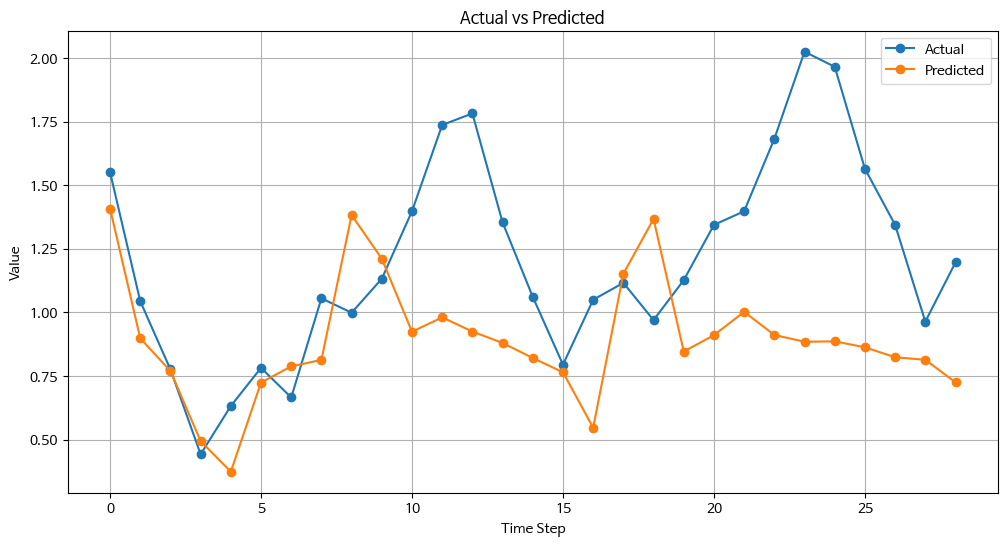

In [244]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

model.eval()  # 평가 모드로 설정
total_loss = 0
predictions = []
actuals = []

with torch.no_grad():  # 그래디언트 계산 비활성화
    for x, y in test_loader:
        # 예측
        output = model(x.unsqueeze(-1))
        
        # 손실 계산
        loss = criterion(output, y)
        total_loss += loss.item()
        
        # 예측값과 실제값 저장
        predictions.extend(output.numpy().flatten())
        actuals.extend(y.numpy().flatten())

# 평균 손실 계산
avg_loss = total_loss / len(test_loader)
print(f'Test Loss: {avg_loss:.4f}')


plt.figure(figsize=(12, 6))
plt.plot(actuals, label='Actual', marker='o')
plt.plot(predictions, label='Predicted', marker='o')
plt.title('Actual vs Predicted')
plt.xlabel('Time Step')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()